# DH - Data Science - Grupo 6.

Integrantes:

*    José Roberto Canales Delgado
*    Matías Sala
*    Luciana Sande
*    Bianca Somadossi

# Desafío 2: Construir un Modelo de Regresión.

Objetivo: desarrollar un modelo de regresión que permita predecir el precio por metro cuadrado de una propiedad.

## 1. Entorno de implementación.

### 1.1 Setup inicial.

In [699]:
# initial setup
%run "common/0_notebooks_base_setup.py"

C:\Users\Lu\Lu\Digital House\grupo_6\DH_grupo_6common
default checking
Running command `conda list`... ok
jupyterlab=2.2.6 already installed
Running command `conda install --yes pandas=1.1.5`... ok
Solving environment: ...working... done

# All requested packages already installed.


bokeh=2.2.3 already installed
seaborn=0.11.0 already installed
matplotlib=3.3.2 already installed
ipywidgets=7.5.1 already installed
Running command `conda install --yes pytest=6.2.1`... ok
Solving environment: ...working... done

# All requested packages already installed.


chardet=4.0.0 already installed
psutil=5.7.2 already installed
Running command `conda install --yes scipy=1.5.2`... ok
Solving environment: ...working... done

# All requested packages already installed.


statsmodels=0.12.1 already installed
Running command `conda install --yes scikit-learn=0.23.2`... ok
Solving environment: ...working... done

# All requested packages already installed.


xlrd=2.0.1 already installed
Running command

<Figure size 432x288 with 0 Axes>

In [700]:
#importamos de todas las librerías que vamos a utilizar

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import linear_model
from lazypredict.Supervised import LazyClassifier, LazyRegressor
import statsmodels.api as sm

%matplotlib inline 


In [701]:
pd.options.display.float_format='{:,.2f}'.format

## 2. Procesamiento de los datos.

### 2.1. Importación del dataset.

In [702]:
#Importaremos el dataset trabajado en el Desafío 1, creando un Dataframe.

data_location = "Data/properati_final.csv"

dataset = pd.read_csv(data_location, sep=",", encoding="UTF-8")


In [703]:
dataset.shape

(44307, 24)

In [704]:
dataset.isna().sum()*100/len(dataset)

property_type              0.00
place_name                 0.05
place_with_parent_names    0.00
state_name                 0.00
lat                        6.36
lon                        6.36
price_aprox_usd            0.00
surface_total_in_m2       20.36
surface_covered_in_m2      0.00
rooms                      0.00
properati_url              0.00
parrilla                   0.00
quincho                    0.00
patio                      0.00
balcon                     0.00
pileta                     0.00
cochera                    0.00
amenities                  0.00
rooms_was_nan              0.00
ciudad                     2.29
barrio                     0.05
subway_distance            0.70
precio_m2                  0.00
segmento_precio_m2         0.00
dtype: float64

<Figure size 720x432 with 0 Axes>

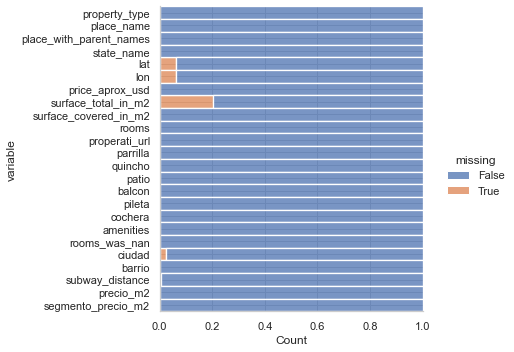

In [705]:
plt.figure(figsize=(10,6))
sns.displot(
    data=dataset.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25)

## 3. Eliminación de outliers.

Verificamos los tipos de propiedad que componen el dataset.

In [706]:
data_property_type = dataset["property_type"]

data_property_type_proportions = 100. * data_property_type.value_counts() / len(data_property_type)
data_property_type_proportions

apartment   63.28
house       28.89
PH           5.08
store        2.75
Name: property_type, dtype: float64

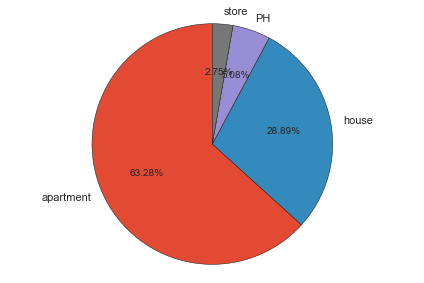

In [707]:
count=dataset["property_type"].value_counts().tolist()
label=dataset["property_type"].value_counts().index

plt.style.use('ggplot')

dic = dict(zip(label,count))

import itertools
newdic={}
for key, group in itertools.groupby(dic, lambda k: 'Others' if (dic[k]<1000) else k):
     newdic[key] = sum([dic[i] for i in list(group)])   

labels = newdic.keys()
sizes = newdic.values()

fig, ax = plt.subplots()

ax.pie(sizes, labels=labels, autopct='%1.2f%%',wedgeprops={"edgecolor":"k"},explode=[0,0,0,0], startangle=90)
ax.axis('equal')
plt.tight_layout()

plt.show()

Relación superficie cubierta en m2 - precio aproximado en USD

Eliminamos las propiedades del tipo Store.

In [708]:
dataset.drop(dataset[(dataset.property_type == 'store')].index, inplace=True)

Text(0.5, 1.0, 'PH')

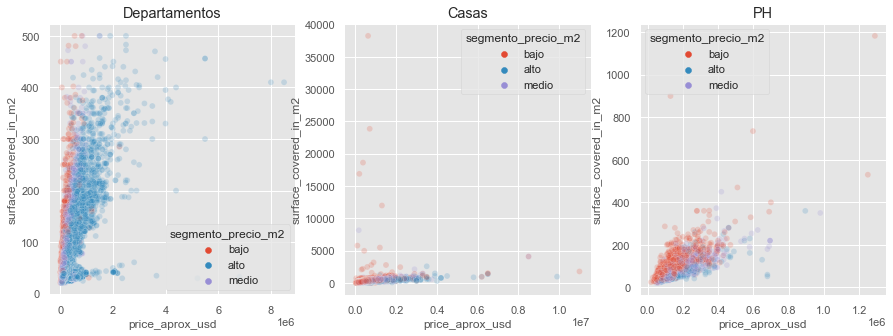

In [709]:
fig, axs = plt.subplots(1,3, figsize=(15, 5))

sns.scatterplot(x=((dataset[(dataset.property_type == 'apartment')].price_aprox_usd)), 
                y=(dataset[(dataset.property_type == 'apartment')].surface_covered_in_m2 ), 
                alpha=0.2, ax=axs[0], hue=dataset['segmento_precio_m2'])


axs[0].set_title("Departamentos")

sns.scatterplot(x=((dataset[(dataset.property_type == 'house')].price_aprox_usd)), 
                y=(dataset[(dataset.property_type == 'house')].surface_covered_in_m2 ), 
                alpha=0.2, ax=axs[1], hue=dataset['segmento_precio_m2'])


axs[1].set_title("Casas")


sns.scatterplot(x=((dataset[(dataset.property_type == 'PH')].price_aprox_usd)), 
                y=(dataset[(dataset.property_type == 'PH')].surface_covered_in_m2 ), 
                alpha=0.2, ax=axs[2], hue=dataset['segmento_precio_m2'])


axs[2].set_title("PH")


In [710]:
dataset.drop(dataset[(dataset.surface_covered_in_m2 >500) & (dataset.property_type == 'apartment')].index, inplace=True)

dataset.drop(dataset[(dataset.surface_covered_in_m2 > 1500) & (dataset.property_type == 'house') ].index, inplace=True)

dataset.drop(dataset[(dataset.surface_covered_in_m2 > 300) & (dataset.property_type == 'PH') ].index, inplace=True)


Text(0.5, 1.0, 'PH')

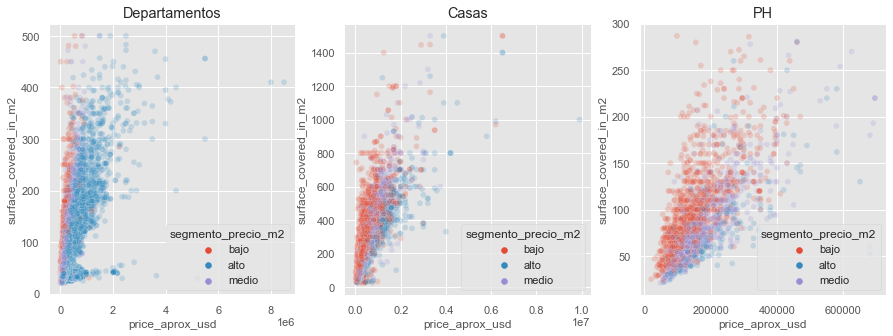

In [711]:
fig, axs = plt.subplots(1,3, figsize=(15, 5))

sns.scatterplot(x=((dataset[(dataset.property_type == 'apartment')].price_aprox_usd)), 
                y=(dataset[(dataset.property_type == 'apartment')].surface_covered_in_m2 ), 
                alpha=0.2, ax=axs[0], hue=dataset['segmento_precio_m2'])


axs[0].set_title("Departamentos")

sns.scatterplot(x=((dataset[(dataset.property_type == 'house')].price_aprox_usd)), 
                y=(dataset[(dataset.property_type == 'house')].surface_covered_in_m2 ), 
                alpha=0.2, ax=axs[1], hue=dataset['segmento_precio_m2'])


axs[1].set_title("Casas")

sns.scatterplot(x=((dataset[(dataset.property_type == 'PH')].price_aprox_usd)), 
                y=(dataset[(dataset.property_type == 'PH')].surface_covered_in_m2 ), 
                alpha=0.2, ax=axs[2], hue=dataset['segmento_precio_m2'])


axs[2].set_title("PH")


In [712]:
dataset["price_aprox_usd"].sample(5)

33357    94,400.00
2614     83,000.00
9586    105,000.00
15073    70,000.00
36359    93,000.00
Name: price_aprox_usd, dtype: float64

In [713]:
dataset.sort_values('price_aprox_usd',ascending=False,inplace=True)

In [714]:
print(dataset["price_aprox_usd"].head(20))

21591   9,900,000.00
17080   8,500,000.00
17079   8,000,000.00
9713    6,809,000.00
13242   6,500,000.00
14289   6,500,000.00
18448   6,500,000.00
7548    6,500,000.00
22412   6,200,000.00
4259    6,200,000.00
17755   5,800,000.00
20368   5,500,000.00
17077   5,500,000.00
22288   5,500,000.00
9285    5,214,782.00
25524   4,500,000.00
20628   4,400,000.00
8682    4,400,000.00
20350   4,200,000.00
33499   4,200,000.00
Name: price_aprox_usd, dtype: float64


In [715]:
dataset_index_outliers = dataset.loc[(dataset["price_aprox_usd"] <= 8000000)]
# dataset.drop(dataset[(dataset.price_aprox_usd <= 8000000)].index, inplace=True)

Text(0.5, 1.0, 'PH')

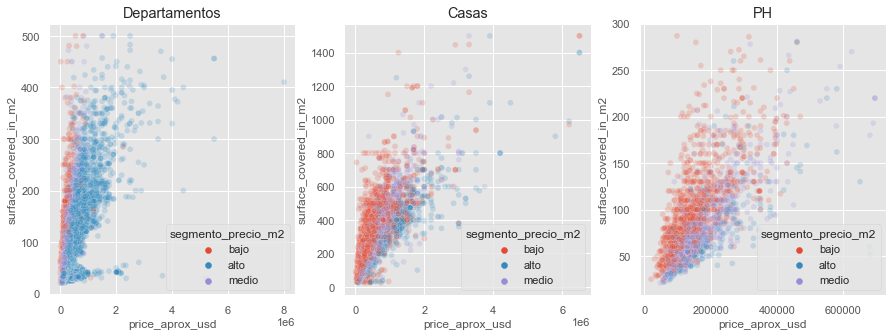

In [716]:
fig, axs = plt.subplots(1,3, figsize=(15, 5))

sns.scatterplot(x=((dataset_index_outliers[(dataset_index_outliers.property_type == 'apartment')].price_aprox_usd)), 
                y=(dataset_index_outliers[(dataset_index_outliers.property_type == 'apartment')].surface_covered_in_m2 ), 
                alpha=0.2, ax=axs[0], hue=dataset_index_outliers['segmento_precio_m2'])


axs[0].set_title("Departamentos")


sns.scatterplot(x=((dataset_index_outliers[(dataset_index_outliers.property_type == 'house')].price_aprox_usd)), 
                y=(dataset_index_outliers[(dataset_index_outliers.property_type == 'house')].surface_covered_in_m2 ), 
                alpha=0.2, ax=axs[1], hue=dataset_index_outliers['segmento_precio_m2'])


axs[1].set_title("Casas")


sns.scatterplot(x=((dataset_index_outliers[(dataset_index_outliers.property_type == 'PH')].price_aprox_usd)), 
                y=(dataset_index_outliers[(dataset_index_outliers.property_type == 'PH')].surface_covered_in_m2 ), 
                alpha=0.2, ax=axs[2], hue=dataset_index_outliers['segmento_precio_m2'])


axs[2].set_title("PH")

## 4. Análisis de relaciones

Observamos la correlación de features luego del tratamiento de los datos.

In [717]:
dataset.columns

Index(['property_type', 'place_name', 'place_with_parent_names', 'state_name',
       'lat', 'lon', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'rooms', 'properati_url', 'parrilla',
       'quincho', 'patio', 'balcon', 'pileta', 'cochera', 'amenities',
       'rooms_was_nan', 'ciudad', 'barrio', 'subway_distance', 'precio_m2',
       'segmento_precio_m2'],
      dtype='object')

In [718]:
dataset.sample(3)

,property_type,place_name,place_with_parent_names,state_name,lat,lon,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,rooms,...,balcon,pileta,cochera,amenities,rooms_was_nan,ciudad,barrio,subway_distance,precio_m2,segmento_precio_m2
34092,apartment,Caballito,|Argentina|Capital Federal|Caballito|,Capital Federal,-34.62,-58.44,"71,528.00",43.00,36.00,1,...,1,0,0,1,0,Caballito,Caballito,0.25,"1,663.44",bajo
15286,house,Villa Devoto,|Argentina|Capital Federal|Villa Devoto|,Capital Federal,-34.60,-58.52,"300,000.00",nan,154.00,4,...,0,0,0,2,0,Villa Devoto,Villa Devoto,4.51,"2,153.77",medio
7986,apartment,Once,|Argentina|Capital Federal|Once|,Capital Federal,-34.61,-58.41,"135,000.00",86.00,86.00,3,...,1,0,0,1,0,Once,Once,0.23,"1,569.77",bajo


(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0.5, 0, 'surface_total_in_m2'),
  Text(1.5, 0, 'price_aprox_usd'),
  Text(2.5, 0, 'surface_covered_in_m2'),
  Text(3.5, 0, 'rooms'),
  Text(4.5, 0, 'subway_distance')])

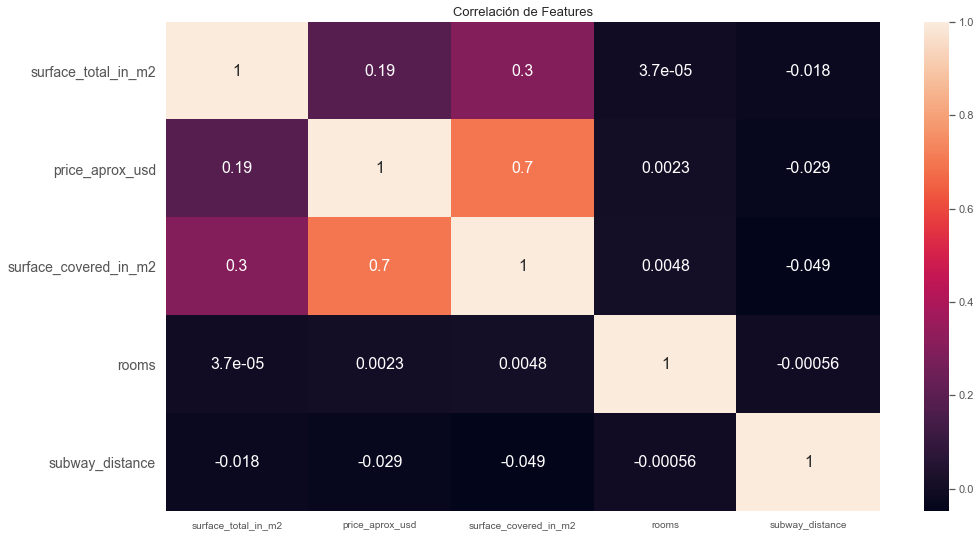

In [719]:
plt.figure(figsize=(16,9))
sns.heatmap(
    dataset[
        ['surface_total_in_m2','price_aprox_usd','surface_covered_in_m2','property_type','rooms','subway_distance']]
    .corr(), annot=True, annot_kws={"size": 16})
plt.title('Correlación de Features', fontsize=13)
plt.yticks(fontsize=14, rotation=0)
plt.xticks(fontsize=10)

In [720]:
dataset = dataset.drop('surface_total_in_m2',axis =1, inplace=True)

## 5. Generación del Modelo

### 5.1 Definición de las columnas a utilizar

Elegimos las columnas que son significativas para la predicción:

* surface_covered_in_m2
* place_with_parent_names
* price_aprox_usd
* property_type
* rooms
* subway_distance


### 5.2 LazyPredict

*https://www.themachinelearners.com/lazypredict/*

¿Qué es? Una librería de Python que nos ayudara saber qué modelos son los mejores para los datos con los que estamos trabajando.
LazyPredict nos permite, con una línea, lanzar una barbaridad de modelos de regresión de scikit-Learn (38) con los parámetros por defecto para ver el rendimiento de cada uno de ellos. 
Esto nos da la ventaja de ver el rendimiento de cada uno de ellos para nuestros datos y poder enfocar en optimizar aquellos que mejor funcionan para nuestros datos.

In [721]:
capital_dataset = pd.read_csv("Data/capital_federal_data.csv", sep=",", encoding="UTF-8")
# capital_dataset = capital_dataset.drop('surface_total_in_m2', inplace=True)
# zona_norte_dataset = pd.read_csv("Data/zona_norte_data.csv", sep=",", encoding="UTF-8")

Separo el dataset en features dependientes e independientes

In [722]:
X_c = capital_dataset[['surface_covered_in_m2', 'lat', 'lon', 'precio_m2','subway_distance']]
y_c = capital_dataset.price_aprox_usd

# X_zn = zona_norte_dataset[['surface_covered_in_m2', 'lat', 'lon', 'precio_m2']]
# y_zn = zona_norte_dataset.price_aprox_usd

Divido el dataset en entrenamiento y prueba

In [723]:
X_c_train, X_c_test, y_c_train, y_c_test = train_test_split(X_c, y_c, random_state= 7)
# X_zn_train, X_zn_test, y_zn_train, y_zn_test = train_test_split(X_zn, y_zn, random_state= 7)

Creo un objeto de la clase LazyRegressor

In [724]:
rg = LazyRegressor(verbose=0,ignore_warnings=False,  custom_metric=None)

Ajustamos nuestros datos de entrenamiento y prueba al objeto LazyClassifier

In [725]:
models,predictions_c = rg.fit(X_c_train, X_c_test, y_c_train, y_c_test)

 21%|█████████████████▊                                                                 | 9/42 [00:04<00:18,  1.77it/s]

GaussianProcessRegressor model failed to execute
Unable to allocate 2.43 GiB for an array with shape (18051, 18051) and data type float64


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [01:36<00:00,  2.31s/it]


Como métricas para regresión están el R cuadrado y el RMSE por defecto, pero podemos elegir la métrica que queramos con el atributo custom_metric

In [726]:
predictions_c

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ExtraTreesRegressor,0.91,0.91,"105,293.34",2.65
RandomForestRegressor,0.90,0.90,"111,834.98",5.17
BaggingRegressor,0.90,0.90,"111,846.77",0.52
GradientBoostingRegressor,0.89,0.89,"117,331.28",1.74
XGBRegressor,0.85,0.85,"133,012.04",0.48
LGBMRegressor,0.85,0.85,"133,329.25",0.24
KNeighborsRegressor,0.82,0.82,"146,842.33",0.13
HistGradientBoostingRegressor,0.80,0.80,"157,092.46",0.51
DecisionTreeRegressor,0.79,0.79,"159,735.47",0.09


Visualizamos los resultados de las métricas de cada modelo.

[(0.0, 1.0)]

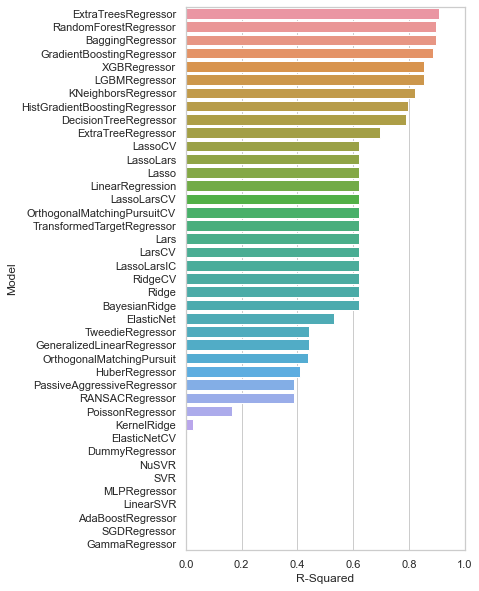

In [727]:
predictions_c["R-Squared"] = [0 if i < 0 else i for i in predictions_c.iloc[:,0] ]
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_c.index, x="R-Squared", data=predictions_c)
ax.set(xlim=(0, 1))

In [728]:
# models,predictions_zn = rg.fit(X_zn_train, X_zn_test, y_zn_train, y_zn_test)

In [729]:
# predictions_zn

In [730]:
# predictions_zn["R-Squared"] = [0 if i < 0 else i for i in predictions_zn.iloc[:,0] ]
# plt.figure(figsize=(5, 10))
# sns.set_theme(style="whitegrid")
# ax = sns.barplot(y=predictions_zn.index, x="R-Squared", data=predictions_zn)
# ax.set(xlim=(0, 1))

## 6. Regresión Lineal Simple

In [731]:
# defino una fx que calcule la Raiz del Error cuadrático medio (RMSE) y r2, imprima sus resultados y los devuelva.

def error(ground_truth, prediction):

    r2 = r2_score(ground_truth, prediction)
    RMSE = mean_squared_error(ground_truth, prediction, squared= False)

    print('R2:' ,r2)
    print ('RMSE:' , round(RMSE))

    return r2, RMSE

Calculo los precios promedio del dataset total y de los data ser separados por zona (Capital Federal y Zona Norte Pcia. Bs. As.)

In [732]:
#Precio promedio Capital Federal
c_price_mean = capital_dataset.price_aprox_usd.mean()
c_price_mean

272721.4149320703

In [733]:
#Precio promedio Zona Norte Pcia. Bs. As.
# zn_price_mean = zona_norte_dataset.price_aprox_usd.mean()
# zn_price_mean

Creo series con cada precio promedio.

In [734]:
c_price_mean = pd.Series([c_price_mean])
# zn_price_mean = pd.Series([zn_price_mean])

In [735]:
c_price_mean = c_price_mean.repeat(len(capital_dataset.price_aprox_usd))
c_price_mean

0   272,721.41
0   272,721.41
0   272,721.41
0   272,721.41
0   272,721.41
       ...    
0   272,721.41
0   272,721.41
0   272,721.41
0   272,721.41
0   272,721.41
Length: 24069, dtype: float64

In [736]:
# zn_price_mean = zn_price_mean.repeat(len(zona_norte_dataset.price_aprox_usd))
# zn_price_mean

Calculo el r2 y el RMSE con la función que definimos al principio.

In [737]:
c_r2_mean, c_RMSE_mean = error(c_price_mean, capital_dataset.price_aprox_usd)
# zn_r2_mean, zn_RMSE_mean = error(zn_price_mean, zona_norte_dataset.price_aprox_usd)

R2: 0.0
RMSE: 362941


Defino una función para calcular un modelo de regresión lineal simple.

In [738]:
def reg_lineal_simple(data, feature):

    X = data[[feature]] #training data
    y = data.price_aprox_usd #target values

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 7) #separamos en entrenamiento y prueba

    lm = linear_model.LinearRegression()
    model = lm.fit(X, y) #creamos una instancia de la clase LinearRegression y fiteamos o ajustamos el modelo

    predictions = lm.predict(X_test) #predecimos usando el modelo lineal

    cv = cross_validate(estimator=linear_model.LinearRegression(), X=X_train, y=y_train, scoring = ['neg_root_mean_squared_error', 'r2'], cv=3)

    sns.scatterplot(data=data, x=feature, y="price_aprox_usd", hue= 'segmento_precio_m2')
    plt.plot(X_train, model.predict(X_train), color='red', linewidth=2)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    return cv

Calculo los modelos de regresión lineal simple, llamando a la función que creamos.

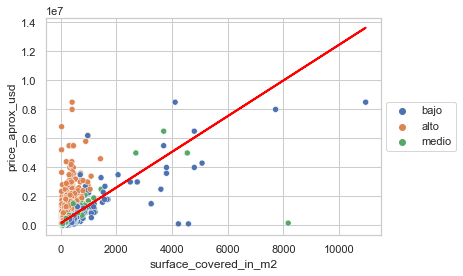

In [739]:
#Calculo el modelo del dataset de Capital Federal.
cv_capital = reg_lineal_simple(capital_dataset, 'surface_covered_in_m2')

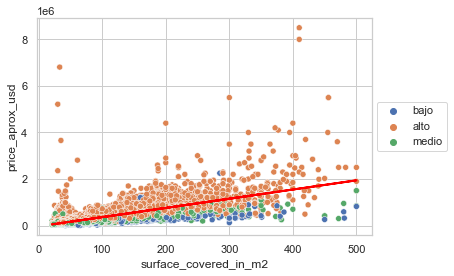

In [740]:
#Calculo el modelo para departamentos en Capital Federal.
c_depto = capital_dataset[capital_dataset.property_type == 'apartment']
cv_c_depto = reg_lineal_simple(c_depto, 'surface_covered_in_m2')

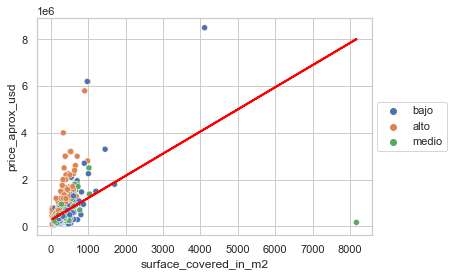

In [741]:
#Calculo el modelo para casas en Capital Federal.
c_casa = capital_dataset[capital_dataset.property_type == 'house']
cv_c_casa = reg_lineal_simple(c_casa, 'surface_covered_in_m2')

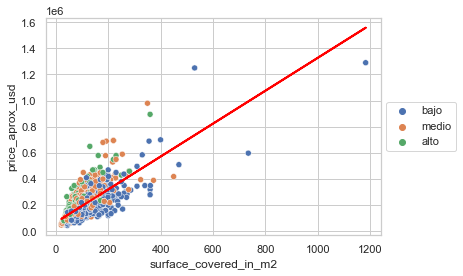

In [742]:
#Calculo el modelo para ph en Capital Federal.
c_ph = capital_dataset[capital_dataset.property_type == 'PH']
cv_c_ph = reg_lineal_simple(c_ph, 'surface_covered_in_m2')

Creamos un diccionario con todos los RMSE que calculamos para visualizar los resultados en un gráfico.

In [743]:
rmse_dict_c = {
    'RMSE_capital' : cv_capital['test_neg_root_mean_squared_error'],
    'RMSE_c_depto' : cv_c_depto['test_neg_root_mean_squared_error'],
    'RMSE_c_casa':cv_c_casa['test_neg_root_mean_squared_error'],
    'RMSE_c_ph':cv_c_ph['test_neg_root_mean_squared_error'],
    'RMSE_promedio_c' : c_RMSE_mean
    }

In [744]:
c_RMSE_mean

362941.1766690629

In [745]:
c_plot = pd.DataFrame(rmse_dict_c)

In [746]:
c_plot[['RMSE_capital','RMSE_c_depto', 'RMSE_c_casa', 'RMSE_c_ph','RMSE_promedio_c']] = c_plot[['RMSE_capital','RMSE_c_depto', 'RMSE_c_casa', 'RMSE_c_ph','RMSE_promedio_c']] * -1


<AxesSubplot:>

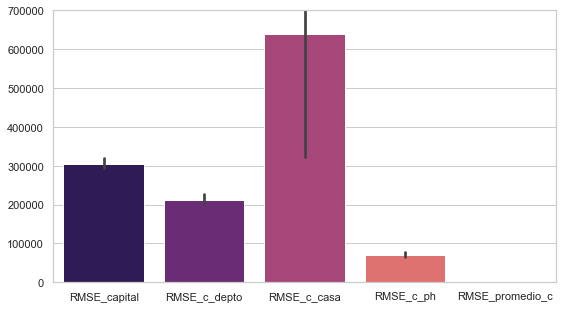

In [747]:
plt.figure(figsize=(9, 5))
plt.ylim(0, 700000)
sns.barplot(data=c_plot, palette= 'magma')

In [748]:
c_plot.to_csv('./data/RMSE_lineal_simple_capital.csv', index=False)

## 7. Regresión Lineal Múltiple

Defino una función para calcular un modelo de regresión lineal múltiple.

In [749]:
def reg_lineal_multiple(data, features):

    X = data[features]
    y = data.price_aprox_usd

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 7)

    #Ajuste del modelo usando statsmodels
    X = sm.add_constant(X_train)

    lm = sm.OLS(y_train, X_train).fit() 
    

    cv = cross_validate(estimator=linear_model.LinearRegression(), X=X_train, y=y_train, scoring=['neg_root_mean_squared_error', 'r2'], cv=3)


    return cv, lm

In [750]:
capital_dataset = capital_dataset.dropna(subset=["surface_covered_in_m2"])
capital_dataset = capital_dataset.dropna(subset=["lat"])
capital_dataset = capital_dataset.dropna(subset=["lon"])
capital_dataset = capital_dataset.dropna(subset=["precio_m2"])
capital_dataset = capital_dataset.dropna(subset=["subway_distance"])
c_depto = capital_dataset[capital_dataset.property_type == 'apartment']
c_ph = capital_dataset[capital_dataset.property_type == 'PH']
c_casa = capital_dataset[capital_dataset.property_type == 'house']

In [751]:
cv_capital, lm_capital = reg_lineal_multiple(capital_dataset,['surface_covered_in_m2', 'lat', 'lon', 'precio_m2','subway_distance'])

In [752]:
lm_capital.summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:        price_aprox_usd   R-squared (uncentered):                   0.683
Model:                            OLS   Adj. R-squared (uncentered):              0.683
Method:                 Least Squares   F-statistic:                              7681.
Date:                Fri, 04 Feb 2022   Prob (F-statistic):                        0.00
Time:                        17:48:43   Log-Likelihood:                     -2.4713e+05
No. Observations:               17820   AIC:                                  4.943e+05
Df Residuals:                   17815   BIC:                                  4.943e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
surface_covered_in_m2  1277.4793     11.123    114.847      0.000    1255.676    1299.282
lat                    2.784e+05   4.68e+04      5.951      0.000    1.87e+05     3.7e+05
lon                   -1.653e+05   2.77e+04     -5.968      0.000    -2.2e+05   -1.11e+05
precio_m2                41.8397      0.542     77.166      0.000      40.777      42.902
subway_distance         -84.7801    394.649     -0.215      0.830    -858.330     688.770
==============================================================================
Omnibus:                    12567.405   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         62449000.630
Skew:                           1.677   Prob(JB):                         0.00
Kurtosis:                     292.992   Cond. No.                     1.33e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.33e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [753]:
cv_capital

{'fit_time': array([0.0039866 , 0.00599527, 0.00300193]),
 'score_time': array([0.00300646, 0.00199771, 0.00499892]),
 'test_neg_root_mean_squared_error': array([-238122.77226656, -294371.4975656 , -236973.02776033]),
 'test_r2': array([0.55487531, 0.4191704 , 0.52379116])}

In [754]:
X_capital = capital_dataset[['surface_covered_in_m2', 'lat', 'lon', 'precio_m2','subway_distance']]
y_capital = capital_dataset.price_aprox_usd
X_c_train, X_c_test, y_c_train, y_c_test = train_test_split(X_capital, y_capital, random_state=7)

In [755]:
#errores en test capital
predictions_c = lm_capital.predict(X_c_test)

error(y_c_test, predictions_c)

R2: 0.5197831715266785
RMSE: 249868


(0.5197831715266785, 249868.18998066045)

In [756]:
#errores en train total
predictions_c = lm_capital.predict(X_c_train)

error(y_c_train, predictions_c)

R2: 0.5054165656808374
RMSE: 255042


(0.5054165656808374, 255041.6527878228)

### Capital Federal - departamentos

In [757]:
cv_depto, lm_depto = reg_lineal_multiple(c_depto,['surface_covered_in_m2', 'lat', 'lon', 'precio_m2','subway_distance'] )
lm_depto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:        price_aprox_usd   R-squared (uncentered):                   0.846
Model:                            OLS   Adj. R-squared (uncentered):              0.846
Method:                 Least Squares   F-statistic:                          1.643e+04
Date:                Fri, 04 Feb 2022   Prob (F-statistic):                        0.00
Time:                        17:48:43   Log-Likelihood:                     -2.0010e+05
No. Observations:               14981   AIC:                                  4.002e+05
Df Residuals:                   14976   BIC:                                  4.002e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
surface_covered_in_m2  3924.9594     22.737    172.627      0.000    3880.393    3969.526
lat                     1.65e+05   3.11e+04      5.314      0.000    1.04e+05    2.26e+05
lon                   -9.489e+04   1.84e+04     -5.161      0.000   -1.31e+05   -5.88e+04
precio_m2                40.5242      0.339    119.648      0.000      39.860      41.188
subway_distance        2527.8731    749.452      3.373      0.001    1058.856    3996.890
==============================================================================
Omnibus:                    21468.795   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         32377395.602
Skew:                           7.942   Prob(JB):                         0.00
Kurtosis:                     230.194   Cond. No.                     1.43e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.43e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [758]:
cv_depto

{'fit_time': array([0.00599456, 0.00500369, 0.00299954]),
 'score_time': array([0.00299954, 0.00399661, 0.00300193]),
 'test_neg_root_mean_squared_error': array([-156066.87819308, -143080.88586834, -156149.42564948]),
 'test_r2': array([0.74816234, 0.75678981, 0.73733042])}

### Capital Federal - casas

In [759]:
cv_casa, lm_casa = reg_lineal_multiple(c_casa,['surface_covered_in_m2', 'lat', 'lon', 'precio_m2','subway_distance'] )
lm_casa.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:        price_aprox_usd   R-squared (uncentered):                   0.653
Model:                            OLS   Adj. R-squared (uncentered):              0.652
Method:                 Least Squares   F-statistic:                              443.3
Date:                Fri, 04 Feb 2022   Prob (F-statistic):                   1.64e-267
Time:                        17:48:43   Log-Likelihood:                         -17028.
No. Observations:                1181   AIC:                                  3.407e+04
Df Residuals:                    1176   BIC:                                  3.409e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
surface_covered_in_m2   846.9496     42.959     19.715      0.000     762.664     931.235
lat                    1.712e+06   3.45e+05      4.969      0.000    1.04e+06    2.39e+06
lon                   -1.019e+06   2.04e+05     -4.996      0.000   -1.42e+06   -6.19e+05
precio_m2                60.4243      7.496      8.061      0.000      45.717      75.131
subway_distance       -7.474e+04   9363.450     -7.982      0.000   -9.31e+04   -5.64e+04
==============================================================================
Omnibus:                      612.492   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           313509.399
Skew:                           1.018   Prob(JB):                         0.00
Kurtosis:                      82.793   Cond. No.                     7.59e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 7.59e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [760]:
cv_casa


{'fit_time': array([0.005023  , 0.00399137, 0.00300097]),
 'score_time': array([0.00398993, 0.00299454, 0.00199914]),
 'test_neg_root_mean_squared_error': array([-550365.26752773, -383604.40433419, -905924.41080739]),
 'test_r2': array([ 0.3352473 ,  0.40822885, -4.05384419])}

### Capital Federal - PH

In [761]:
cv_ph, lm_ph = reg_lineal_multiple(c_ph,['surface_covered_in_m2', 'lat', 'lon', 'precio_m2','subway_distance'] )
lm_ph.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:        price_aprox_usd   R-squared (uncentered):                   0.912
Model:                            OLS   Adj. R-squared (uncentered):              0.911
Method:                 Least Squares   F-statistic:                              2185.
Date:                Fri, 04 Feb 2022   Prob (F-statistic):                        0.00
Time:                        17:48:43   Log-Likelihood:                         -13298.
No. Observations:                1063   AIC:                                  2.661e+04
Df Residuals:                    1058   BIC:                                  2.663e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
surface_covered_in_m2  1292.2028     29.524     43.768      0.000    1234.271    1350.134
lat                    3.685e+05   4.86e+04      7.579      0.000    2.73e+05    4.64e+05
lon                   -2.187e+05   2.88e+04     -7.599      0.000   -2.75e+05   -1.62e+05
precio_m2                19.2866      2.132      9.047      0.000      15.103      23.470
subway_distance       -1604.0722    860.798     -1.863      0.063   -3293.139      84.994
==============================================================================
Omnibus:                      355.184   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5893.452
Skew:                           1.081   Prob(JB):                         0.00
Kurtosis:                      14.331   Cond. No.                     5.73e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 5.73e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [762]:
cv_ph

{'fit_time': array([0.00699663, 0.00200248, 0.00299859]),
 'score_time': array([0.00199914, 0.00299907, 0.00199986]),
 'test_neg_root_mean_squared_error': array([-71881.69166662, -69704.57012425, -57474.86737887]),
 'test_r2': array([0.61038381, 0.65687868, 0.66110274])}

Creamos un diccionario con todos los RMSE que calculamos para visualizar los resultados en un gráfico.

In [763]:
rmse_dict = {
    'RMSE_ph' : cv_ph['test_neg_root_mean_squared_error'] ,
    'RMSE_casa':cv_casa['test_neg_root_mean_squared_error'],
    'RMSE_depto':cv_depto['test_neg_root_mean_squared_error'],
    'RMSE_capital':cv_capital['test_neg_root_mean_squared_error'], 
}

In [764]:
df_plot = pd.DataFrame(rmse_dict)

In [765]:
df_plot[['RMSE_capital','RMSE_casa', 'RMSE_depto', 'RMSE_ph']] = df_plot[['RMSE_capital','RMSE_casa', 'RMSE_depto', 'RMSE_ph']] * -1

In [766]:
df_plot['model'] = 'multivariable'

<AxesSubplot:>

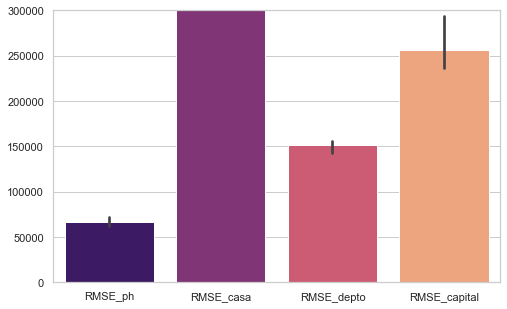

In [767]:
plt.figure(figsize=(8, 5))
plt.ylim(0, 300000)
sns.barplot(data=df_plot, palette= 'magma')

In [768]:
df_RMSE_lineal = pd.read_csv('./data/RMSE_lineal_simple_capital.csv')

In [769]:
df_RMSE_lineal['model'] ='lineal'

In [770]:
df_plot = pd.concat([df_RMSE_lineal,df_plot])

In [771]:
df_plot = pd.melt(df_plot, id_vars=['model'])

In [772]:
df_plot.sample(2)

,model,variable,value
29,multivariable,RMSE_promedio_c,nan
5,multivariable,RMSE_capital,"236,973.03"


<AxesSubplot:xlabel='variable', ylabel='value'>

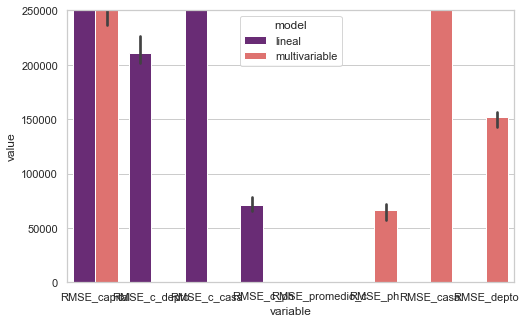

In [773]:
plt.figure(figsize=(8, 5))
plt.ylim(0, 250000)
sns.barplot(data= df_plot, x ='variable', y= 'value', hue= 'model', palette= 'magma')

### Regularización.

L2 = Regularización con Ridge. Sobre data set de Capital Federal.

In [774]:
# Regularización con Ridge

from sklearn.preprocessing import StandardScaler

X = capital_dataset[['lat', 'lon', 'surface_covered_in_m2', 'subway_distance', 'precio_m2']]

scaler = StandardScaler()

X_std = scaler.fit_transform(X)

y = capital_dataset['price_aprox_usd']

In [775]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size = 0.3, random_state = 117)

model_ridge_cv = linear_model.RidgeCV(alphas= [0.3, 0.5, 1.0, 1.1, 1.15, 1.17, 1.18, 1.19, 1.2, 1.21, 1.22, 1.3, 1.4, 1.5, 10.0, 20, 50, 100], 
                                   fit_intercept=True, scoring='neg_root_mean_squared_error', normalize=False, cv=10)

model_fit_ridge_cv = model_ridge_cv.fit(X_train, y_train)

print('El mejor valor de  𝜆  es:')
print(model_fit_ridge_cv.alpha_)
print('El valor de  𝑅MSE  en train es:')
print(model_fit_ridge_cv.best_score_)

El mejor valor de  𝜆  es:
100.0
El valor de  𝑅MSE  en train es:
-257977.6947321117


In [776]:
best_alpha = model_fit_ridge_cv.alpha_
model_ridge = linear_model.Ridge(alpha = best_alpha, fit_intercept = True, normalize = False)
model_fit_ridge = model_ridge.fit(X_train, y_train)
print(model_fit_ridge.coef_)
print(model_fit_ridge.intercept_)
print(model_fit_ridge.score(X_train, y_train))

[ 74634.48016556  55641.98986659 214449.19422327  58580.37026746
 138805.61165123]
272110.9909357963
0.5162594795457716


In [777]:
pred= model_fit_ridge.predict(X_test)

In [778]:
r2, RMSE_ridge = error(y_test, pred)

R2: 0.542921761298355
RMSE: 242786


In [779]:
df_plot = df_plot.append({'model': 'Ridge' ,'variable': 'RMSE',	'value' : RMSE_ridge}, ignore_index=True)

In [780]:
df_plot

,model,variable,value
0,lineal,RMSE_capital,"318,790.34"
1,lineal,RMSE_capital,"294,276.03"
2,lineal,RMSE_capital,"301,462.75"
3,multivariable,RMSE_capital,"238,122.77"
4,multivariable,RMSE_capital,"294,371.50"
5,multivariable,RMSE_capital,"236,973.03"
6,lineal,RMSE_c_depto,"204,716.14"
7,lineal,RMSE_c_depto,"201,267.50"
8,lineal,RMSE_c_depto,"226,486.29"
9,multivariable,RMSE_c_depto,nan


<AxesSubplot:xlabel='model', ylabel='value'>

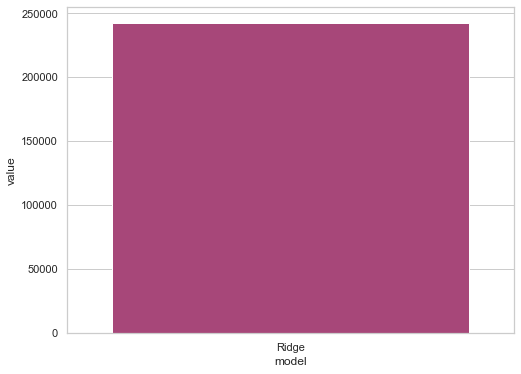

In [781]:
plt.figure(figsize=(8, 6))
sns.barplot(x = 'model', y= 'value', data= df_plot[df_plot.variable == 'RMSE'], palette='magma')

### Lasso.

In [782]:
X_train

array([[ 0.04595156,  0.11260981, -0.24789271, -0.13965939, -0.14977757],
       [ 0.95333417, -0.39634136, -0.32258159, -0.17092327, -0.02750499],
       [ 0.85197024,  0.08861275,  0.32663715, -0.02972663,  0.19535397],
       ...,
       [-0.06304122,  0.76714165, -0.11000554, -0.15291203, -0.26506059],
       [ 1.01403431, -0.40301523, -0.39727047, -0.21713745, -0.05959668],
       [-0.86243837,  1.44727313,  0.03937222,  0.25354221, -0.76071096]])

In [783]:
alphas = np.logspace(-2,7,20)

error_test_lista = []
error_train_lista = []

params = pd.DataFrame()

for alpha in alphas:
#     print(alpha, end = ', ')
    lasso = linear_model.Lasso(alpha = alpha)
    lasso.fit(X_train, y_train)
    params = pd.concat([params,pd.DataFrame({f'{alpha}':lasso.coef_})], axis = 1)
    
    error_train = mean_squared_error(y_train, lasso.predict(X_train), squared=False)
    error_test  = mean_squared_error(y_test,  lasso.predict(X_test), squared=False)
    
    error_test_lista.append( error_test )
    error_train_lista.append(error_train)

In [784]:
alphas

array([1.00000000e-02, 2.97635144e-02, 8.85866790e-02, 2.63665090e-01,
       7.84759970e-01, 2.33572147e+00, 6.95192796e+00, 2.06913808e+01,
       6.15848211e+01, 1.83298071e+02, 5.45559478e+02, 1.62377674e+03,
       4.83293024e+03, 1.43844989e+04, 4.28133240e+04, 1.27427499e+05,
       3.79269019e+05, 1.12883789e+06, 3.35981829e+06, 1.00000000e+07])

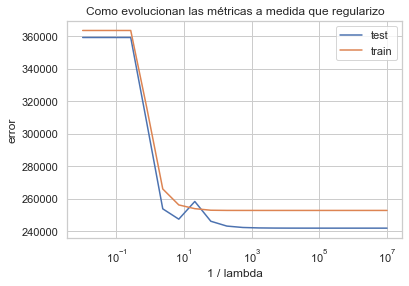

In [785]:
plt.plot(alphas[::-1], error_test_lista, label = 'test')
plt.plot(alphas[::-1], error_train_lista, label = 'train')


plt.title('Como evolucionan las métricas a medida que regularizo')
plt.legend()
plt.xlabel('1 / lambda')
plt.ylabel('error')
plt.xscale('log')
plt.show()

In [786]:
error_test_lista

[241858.6032189112,
 241858.6465704457,
 241858.77560030858,
 241859.1596469769,
 241860.30279307193,
 241863.70602030447,
 241873.84496380124,
 241904.08583378646,
 241994.6788080093,
 242269.4950254056,
 243133.10425523057,
 246101.41206635992,
 258261.67713658256,
 247382.50816031802,
 253737.3781121963,
 306735.7068938969,
 359111.92096960405,
 359111.92096960405,
 359111.92096960405,
 359111.92096960405]

In [787]:
params

,0.01,0.029763514416313176,0.08858667904100823,0.26366508987303583,0.7847599703514611,2.3357214690901213,6.951927961775605,20.69138081114788,61.584821106602604,183.29807108324337,545.5594781168514,1623.776739188721,4832.930238571752,14384.498882876629,42813.32398719387,127427.49857031321,379269.0190732246,1128837.8916846884,3359818.2862837743,10000000.0
0,"76,807.95","76,807.84","76,807.52","76,806.54","76,803.65","76,795.02","76,769.59","76,693.66","76,467.65","75,794.96","73,793.06","67,856.14","50,192.63","27,806.67",0.00,0.00,0.00,0.00,0.00,0.00
1,"56,823.32","56,823.24","56,823.03","56,822.41","56,820.54","56,814.98","56,798.55","56,749.53","56,603.62","56,169.34","54,876.88","51,039.16","39,619.67","19,580.75",0.00,0.00,0.00,0.00,0.00,0.00
2,"215,792.36","215,792.34","215,792.29","215,792.11","215,791.59","215,790.05","215,785.45","215,771.76","215,731.02","215,609.75","215,248.81","214,174.07","210,975.13","200,697.46","169,917.01","78,423.23",0.00,0.00,0.00,0.00
3,"63,202.85","63,202.60","63,201.86","63,199.66","63,193.11","63,173.61","63,115.81","62,943.55","62,430.80","60,904.67","56,362.65","42,865.14","2,698.59",0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00
4,"139,630.57","139,630.56","139,630.50","139,630.33","139,629.84","139,628.38","139,624.02","139,611.05","139,572.45","139,457.56","139,115.59","138,097.67","135,067.94","127,691.32","102,502.29","23,025.92",0.00,0.00,0.00,0.00


In [788]:
df_plot = df_plot.append({'model': 'Lasso' ,'variable': 'RMSE',	'value' : error_test_lista[0]}, ignore_index=True)

In [789]:
params_to_plot = params
alphas_to_plot = params_to_plot.columns
alphas_to_plot = np.array(alphas_to_plot, dtype = 'float')

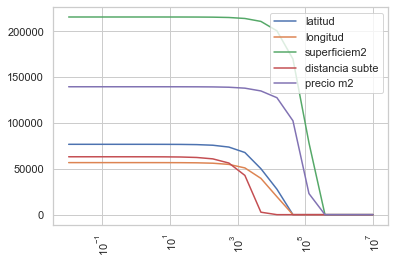

In [790]:
plt.plot(alphas_to_plot, np.abs(params_to_plot.loc[0].values), label = 'latitud')
plt.plot(alphas_to_plot, np.abs(params_to_plot.loc[1].values), label = 'longitud')
plt.plot(alphas_to_plot, np.abs(params_to_plot.loc[2].values), label = 'superficiem2')
plt.plot(alphas_to_plot, np.abs(params_to_plot.loc[3].values), label = 'distancia subte')
plt.plot(alphas_to_plot, np.abs(params_to_plot.loc[4].values), label = 'precio m2')

plt.legend()
plt.xticks(rotation = 90)
plt.xscale('log')
plt.show()

<AxesSubplot:xlabel='model', ylabel='value'>

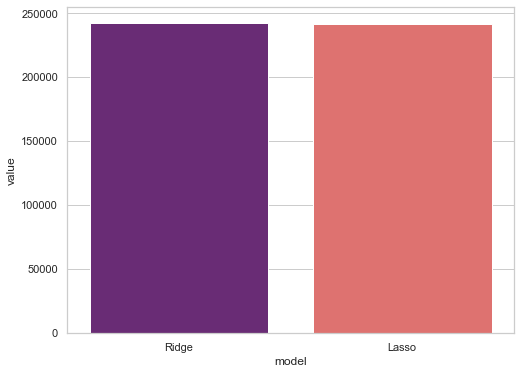

In [791]:
plt.figure(figsize=(8, 6))
sns.barplot(x = 'model', y= 'value', data= df_plot[df_plot.variable == 'RMSE'], palette='magma')